In [5]:
from datetime import datetime

In [3]:
import numpy as np
import yfinance as yf
import scipy.optimize as optimize

In [16]:
import plotly.express as px

In [61]:
SYMBOL = "MSFT"
START_DATE = datetime(2011, 1, 1)
END_DATE = datetime(2022, 1, 1)

In [62]:
def get_returns_from_yahoo(symbol: str, start_date: datetime, end_date: datetime) -> np.ndarray:
    """
    Retrieve historical stock price data from Yahoo Finance and calculate its logarithmic returns.

    Parameters:
    symbol (str): Ticker symbol of the stock (e.g., 'AAPL').
    start_date (datetime): Start date for historical data (e.g., datetime(2022, 1, 1)).
    end_date (datetime): End date for historical data.
    
    Returns:
    numpy.ndarray: Log returns of the specified stock.
    """
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=start_date, end=end_date)["Close"]
    return np.log(data / data.shift(1)).dropna()

In [63]:
data = get_returns_from_yahoo(SYMBOL, START_DATE, END_DATE)

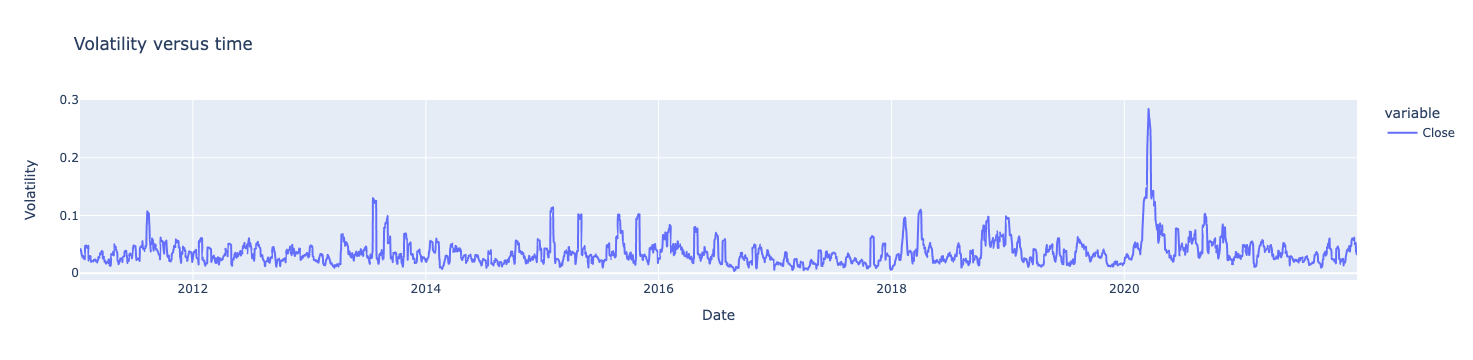

In [77]:
volatility_data = data.rolling(7).std() * np.sqrt(7) #mber of trading days = 252
px.line(volatility_data.dropna(), labels={"value": "Volatility"}, title = "Volatility versus time", )

### Calibrating the model using the Ornstein-Uhlenbeck model
\begin{align}
dX(t) = \theta(\mu - X(t))dt - \sigma dW(t)

\end{align}
Where,
- $X(t)$: State variable.
- $\theta$: The rate at which $X(t)$ reverts to the mean $\mu$.
- $mu$: Long-term mean of $X(t)%$.
- $\sigma$: Volatility of the process.
- $dW(t)$: Weiner Process (Brownian Motion).

We calibrate the above stochastic differential equation using log-likelihood function.
\begin{align}
\log \mathcal{L}(\theta, \mu, \sigma | \mathbf{X}) = -\frac{N}{2} \log(2\pi) - \frac{N}{2} \log(\sigma^2) - \sum_{t=1}^{N} \frac{(X_t - \mu)^2}{2\sigma^2}
\end{align}
Where,
- $N$: Number of data points.

In [78]:
def ornstein_uhlenbeck(params, data):
    """
    Log-Likelihood function of the Ornstein-Uhlenbeck model
    """
    theta, mu, sigma = params
    n = len(data)
    error = data - mu
    log_likelihood = -n / 2 * np.log(2 * np.pi)
    log_likelihood -= n / 2 * np.log(sigma ** 2)
    log_likelihood -= 1 / (2 * sigma ** 2) * np.sum((error - theta) ** 2)
    return -log_likelihood

In [79]:
result = optimize.minimize(ornstein_uhlenbeck, [0.1, 0.2, 0.3], args=(volatility_data,)) # We use random points as our initial points.
theta_opt, mu_opt, sigma_opt = result.x

In [80]:
result.x

array([-0.03188728,  0.06811272, -0.02347639])

### Testing the calculated parameters

In [81]:
START_TEST = datetime(2021, 1, 1)
END_TEST = datetime(2023, 1, 1)
test_data = get_returns_from_yahoo("AAPL", START_TEST, END_TEST)

In [87]:
volatility_test_data = test_data.rolling(7).std() * np.sqrt(7)

In [88]:
volatility_test_data = volatility_test_data.dropna()

In [84]:
dt = 1/ 7
n_days = 7
predictions = np.zeros(n_days)
X_t = volatility_data.iloc[-1]
predictions[0] = X_t
theta, mu, sigma = result.x
for day in range(1, n_days):
    dW_t = np.random.normal(0, 1)
    X_t = X_t + theta * (mu - X_t) * dt + sigma * dW_t
    predictions[day] = X_t



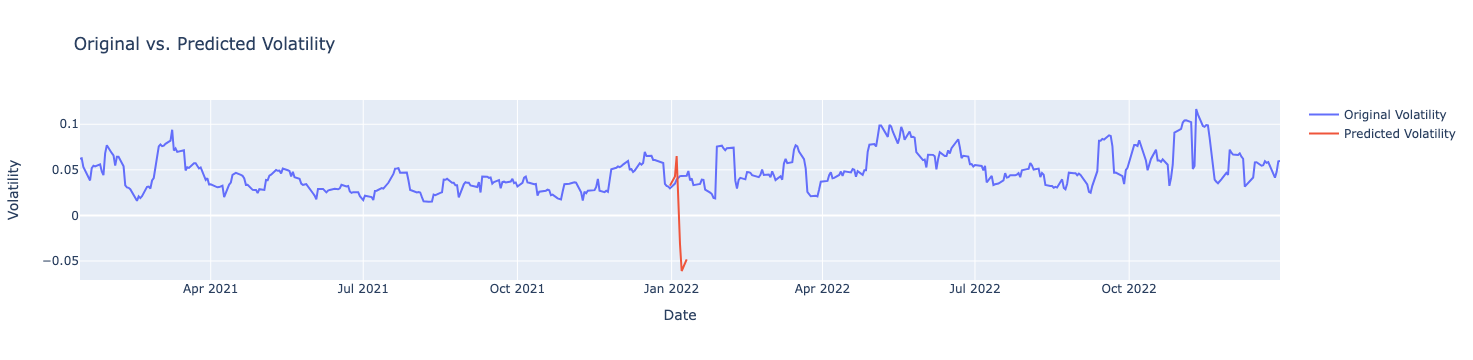

In [89]:
import plotly.graph_objs as go

# Original volatility data
trace1 = go.Scatter(x=volatility_test_data.index, y=volatility_test_data, mode='lines', name='Original Volatility')

# Predicted volatility data
trace2 = go.Scatter(x=test_data.index[-252:], y=predictions, mode='lines', name='Predicted Volatility')

data = [trace1, trace2]

layout = go.Layout(
    title='Original vs. Predicted Volatility',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Volatility'),
)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [90]:
def find_combinations(n, numbers):
    memo = {}  # Memoization cache

    def find_combinations_helper(remaining_n, start_index):
        if (remaining_n, start_index) in memo:
            return memo[(remaining_n, start_index)]

        if remaining_n == 0:
            combinations.append(list(current_combination))
            return

        if remaining_n < 0:
            return

        for i in range(start_index, len(numbers)):
            current_combination.append(numbers[i])
            find_combinations_helper(remaining_n - numbers[i], i)
            current_combination.pop()

        memo[(remaining_n, start_index)] = None  # Memoize result

    combinations = []
    current_combination = []
    find_combinations_helper(n, 0)
    return combinations

# Example usage:
target = 5
number_list = [1, 2, 3, 4, 5]
result = find_combinations(target, number_list)



In [91]:
result

[[1, 1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 3], [1, 2, 2], [1, 4], [2, 3], [5]]